# Pinball Wizard: Building a Model to Predict Pinball Machine Ratings #  
### Nicolas Giraldo-Wingler

In [1]:
## Import all relevant libraries
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import patsy

import statsmodels.api as sm
import statsmodels.formula.api as smf 

from sklearn.linear_model import Lasso, LassoCV, Ridge, ElasticNet, LinearRegression
from sklearn.model_selection import (cross_val_score, train_test_split, 
                                     KFold, GridSearchCV)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats

%matplotlib inline
sns.set()


## Exploratory Data Analysis

In [2]:
path = '/Users/anagiraldo-w/ds/metis/metisgh/bootcamp/PinballScrape/pinball_data.json'
with open(path) as f: 
    raw_data = json.load(f)
pinball_data = pd.DataFrame(raw_data)
pinball_data.head(20)

,features,machine type,manufacture date,manufacturer,mpu,name,number of ratings,production,rating,specialty,theme
0,5,[Electro-mechanical (EM) ],"[August, 1941]",D. Gottlieb & Company (1931-1977),[],[A-B-C Bowler],,[],[],Flipperless,[Sports - Bowling]
1,9,[Electro-mechanical (EM) ],"[November, 1975]",D. Gottlieb & Company (1931-1977),[],[Abra Ca Dabra],56,"[2,825 units ]",[7.8],NaN,[Wizard/Magic]
2,3,[Electro-mechanical (EM) ],[],Bally Manufacturing Corporation (1931-1983),[],[Acapulco],,[],[],Bingo Machine,[Beach - Boating - Happiness - Recreation - Sw...
3,0,[Pure Mechanical (PM) ],"[April, 1932]","Ace Manufacturing Company,",[],[Ace],,[],[],Table Top/Counter Game,[]
4,1,[Electro-mechanical (EM) ],"[August, 1935]",Bally Manufacturing Corporation (1931-1983),[],[Ace],,[],[],Payout Machine,[]
5,0,[Pure Mechanical (PM) ],"[April, 1932]","Pierce Tool and Manufacturing Company,",[],[Ace High],,[],[],Table Top/Counter Game,[Card Game]
6,11,[Electro-mechanical (EM) ],"[February, 1957]",D. Gottlieb & Company (1931-1977),[],[Ace High],19,"[2,100 units ]",[7.7],NaN,[Cards/Gambling]
7,0,[Pure Mechanical (PM) ],"[June, 1931]","Hercules Novelty Company, Incorporated,",[],[Ace Is High],,[],[],Table Top/Counter Game,[Cards/Gambling]
8,4,[Electro-mechanical (EM) ],"[August, 1965]",Bally Manufacturing Corporation (1931-1983),[],[Aces High],Add,"[1,275 units ]",[],NaN,[Gambling - Poker - Riverboat]
9,0,[],[],NaN,[],[],,[],[],NaN,[]


Data is really ugly.  
We will have to remove all brackets, in addition to all other nonsensical terms

In [3]:
def delist(data):
    try: 
        if type(data) == str:
            return data
        elif data == []: 
            return np.nan
        else: 
            return data[0]
    except: 
        return data

def remove_spaces(data):
    if data == '':
        return np.nan
    elif data == 'Add':
        return np.nan
    else:
        return data
    
pinball_data = pinball_data.applymap(delist)
pinball_data = pinball_data.applymap(remove_spaces)
pinball_data['manufacture date'] = pd.to_datetime(pinball_data['manufacture date'])
pinball_data = pinball_data.sort_values(by='manufacture date')
pinball_data.head()

,features,machine type,manufacture date,manufacturer,mpu,name,number of ratings,production,rating,specialty,theme
5354,0,Pure Mechanical (PM),1870-01-01,"M. Redgrave Bagatelle Company,",NaN,Parlor Bagatelle (Two Star / Three Bell),NaN,NaN,NaN,Bagatelle,NaN
4541,0,Pure Mechanical (PM),1871-01-01,"M. Redgrave Bagatelle Company,",NaN,1871 Redgrave Parlor Bagatelle,NaN,NaN,NaN,Bagatelle,NaN
5191,3,Pure Mechanical (PM),1889-01-01,"Nash Manufacturing Company,",NaN,"Unknown (""One Bell"")",NaN,NaN,NaN,Bagatelle,Sports - Baseball
1760,0,Pure Mechanical (PM),1898-01-01,"M. Redgrave Bagatelle Company,",NaN,Parlor Bagatelle (One Star / Two Bell),NaN,NaN,NaN,NaN,NaN
4866,0,Pure Mechanical (PM),1898-01-01,Unknown Manufacturer,NaN,"Parlor Bagatelle (""One Star / One Bell"")",NaN,NaN,NaN,Bagatelle,NaN


In [4]:
pinball_data['days since'] = (pinball_data['manufacture date'] - pd.to_datetime('1870-01-01') ).astype('timedelta64[D]')
pinball_data.head()

,features,machine type,manufacture date,manufacturer,mpu,name,number of ratings,production,rating,specialty,theme,days since
5354,0,Pure Mechanical (PM),1870-01-01,"M. Redgrave Bagatelle Company,",NaN,Parlor Bagatelle (Two Star / Three Bell),NaN,NaN,NaN,Bagatelle,NaN,0.0
4541,0,Pure Mechanical (PM),1871-01-01,"M. Redgrave Bagatelle Company,",NaN,1871 Redgrave Parlor Bagatelle,NaN,NaN,NaN,Bagatelle,NaN,365.0
5191,3,Pure Mechanical (PM),1889-01-01,"Nash Manufacturing Company,",NaN,"Unknown (""One Bell"")",NaN,NaN,NaN,Bagatelle,Sports - Baseball,6940.0
1760,0,Pure Mechanical (PM),1898-01-01,"M. Redgrave Bagatelle Company,",NaN,Parlor Bagatelle (One Star / Two Bell),NaN,NaN,NaN,NaN,NaN,10227.0
4866,0,Pure Mechanical (PM),1898-01-01,Unknown Manufacturer,NaN,"Parlor Bagatelle (""One Star / One Bell"")",NaN,NaN,NaN,Bagatelle,NaN,10227.0


In [5]:
def clean_production(prod_value):
    try:
        return float(re.sub(r'units?', '', str(prod_value)).replace(',', ''))
    except:
        return np.nan
    
pinball_data.production = pinball_data['production'].apply(clean_production)

In [6]:
def clean_ratings_numbers(prod_value):
    return float(re.sub(r'r', '', str(prod_value)))

pinball_data['number of ratings'] = pinball_data['number of ratings'].apply(clean_ratings_numbers)

Now we need to look at ways to deal with missing values.  
Let's look at how many null and unique values various columns have so we can get a feel for what we have to play with. 

In [7]:
len(pinball_data.manufacturer.value_counts())

669

In [8]:
len(pinball_data.specialty.value_counts())

25

In [9]:
pinball_data['machine type'].value_counts()

Electro-mechanical (EM)         3752
Solid State Electronic (SS)     1419
Pure Mechanical (PM)             856
Name: machine type, dtype: int64

In [10]:
pinball_data['specialty'].value_counts()

Flipperless                             509
Bingo Machine                           348
Payout Machine                          308
Table Top/Counter Game                  277
Add-A-Ball                              210
Converted Game                          193
                                        143
Bat Game                                139
Conversion Kit                          125
Mechanical Backbox Animation            123
Widebody                                106
Bagatelle                                94
Horserace Game                           59
Non-Commercial Machine [Home Model]      55
Rolldown Game                            43
Cocktail Table                           37
One Ball Game                            31
Re-themed Game                           29
Head-to-Head Play                        28
Zipper Flippers                          23
Cue Game                                 21
Novelty Play                             21
Redemption Game                 

In [11]:
len(pinball_data['theme'].unique())

1038

In [12]:
len(pinball_data[pd.isna(pinball_data['number of ratings']) == False])

849

In [13]:
pinball_data.isnull().sum()

features                0
machine type          522
manufacture date     1554
manufacturer          434
mpu                  5870
name                  368
number of ratings    5700
production           5163
rating               5700
specialty            3589
theme                2900
days since           1554
dtype: int64

### Conclusion: ##  
- I can't just remove all null values as that leaves me with too little useable data.
- Simply dropping all rows with null values leaves me with **61 rows**  
- We HAVE to remove nulls from target variable, **'rating',** which leaves us with **~850 out of the original ~6500 rows.**   
- Need to explore other avenues so we can still have a good chunk of data to base model off of

In [14]:
pinball_data_clean = pinball_data.dropna(how='all', axis=0)
pinball_data_clean = pinball_data_clean.dropna(how='any', subset=['rating','days since']).reset_index()
pinball_data_clean = pinball_data_clean.drop(['mpu', 'index'], axis=1)

pinball_data_clean

,features,machine type,manufacture date,manufacturer,name,number of ratings,production,rating,specialty,theme,days since
0,0,Electro-mechanical (EM),1936-04-07,Chicago Coin Machine Manufacturing Company (19...,Monopolee,6.0,127.0,6.0,Payout Machine,NaN,24202.0
1,5,Electro-mechanical (EM),1947-10-25,D. Gottlieb & Company (1931-1977),Humpty Dumpty,7.0,6500.0,6.7,NaN,Fictional Characters,28420.0
2,6,Electro-mechanical (EM),1950-12-01,D. Gottlieb & Company (1931-1977),Knock Out,14.0,3000.0,7.1,NaN,Sports - Boxing,29553.0
3,26,Electro-mechanical (EM),1951-02-01,Chicago Coin Machine Manufacturing Company (19...,Thing,6.0,NaN,8.5,NaN,NaN,29615.0
4,7,Electro-mechanical (EM),1951-02-01,D. Gottlieb & Company (1931-1977),Minstrel Man,11.0,1800.0,7.4,NaN,American History - Music - Singing - Dancing,29615.0
5,6,Electro-mechanical (EM),1951-11-01,D. Gottlieb & Company (1931-1977),Globe Trotter,6.0,910.0,7.0,NaN,Airplanes - Aviation - Flying - Travel - World...,29888.0
6,7,Electro-mechanical (EM),1952-06-01,D. Gottlieb & Company (1931-1977),Four Stars,7.0,950.0,6.9,NaN,Girls - Women,30101.0
7,3,Electro-mechanical (EM),1952-11-01,D. Gottlieb & Company (1931-1977),Coronation,7.0,1100.0,8.1,NaN,NaN,30254.0
8,6,Electro-mechanical (EM),1952-12-01,D. Gottlieb & Company (1931-1977),Queen of Hearts,10.0,2200.0,7.5,NaN,Cards/Gambling,30284.0
9,8,Electro-mechanical (EM),1953-04-01,D. Gottlieb & Company (1931-1977),Grand Slam,6.0,1800.0,7.6,NaN,Sports - Baseball,30405.0


In [15]:
pinball_data_clean.isnull().sum()

features               0
machine type           0
manufacture date       0
manufacturer           0
name                   0
number of ratings      0
production           129
rating                 0
specialty            651
theme                 54
days since             0
dtype: int64

In [16]:
type(pinball_data_clean['days since'][0])

numpy.float64

Since 'specialty' and 'theme' are categorical variables for which 'none' is a valid response, I'll replace all null values here with 'none', and use that as its own category when I encode the categorical variables.  
  
"Production" and "Manufacture date" are numerical so we have to go with a different solution here. "Manufacture date" null rows can be dropped since there are only 8 of them. However we have to be very careful about dropping any rows at this point since we are down to ~850 which is on the low side compared to what we started with. 

In [17]:
production_non_nan = pinball_data_clean[pinball_data_clean['production'].isnull() == False]
production_mean = production_non_nan['production'].mean()
production_mean

3539.1446629213483

In [18]:
values = {'specialty': 'none', 'theme': 'none', 'production': production_mean}
pinball_data_clean = pinball_data_clean.fillna(value=values)
pinball_data_clean

,features,machine type,manufacture date,manufacturer,name,number of ratings,production,rating,specialty,theme,days since
0,0,Electro-mechanical (EM),1936-04-07,Chicago Coin Machine Manufacturing Company (19...,Monopolee,6.0,127.000000,6.0,Payout Machine,none,24202.0
1,5,Electro-mechanical (EM),1947-10-25,D. Gottlieb & Company (1931-1977),Humpty Dumpty,7.0,6500.000000,6.7,none,Fictional Characters,28420.0
2,6,Electro-mechanical (EM),1950-12-01,D. Gottlieb & Company (1931-1977),Knock Out,14.0,3000.000000,7.1,none,Sports - Boxing,29553.0
3,26,Electro-mechanical (EM),1951-02-01,Chicago Coin Machine Manufacturing Company (19...,Thing,6.0,3539.144663,8.5,none,none,29615.0
4,7,Electro-mechanical (EM),1951-02-01,D. Gottlieb & Company (1931-1977),Minstrel Man,11.0,1800.000000,7.4,none,American History - Music - Singing - Dancing,29615.0
5,6,Electro-mechanical (EM),1951-11-01,D. Gottlieb & Company (1931-1977),Globe Trotter,6.0,910.000000,7.0,none,Airplanes - Aviation - Flying - Travel - World...,29888.0
6,7,Electro-mechanical (EM),1952-06-01,D. Gottlieb & Company (1931-1977),Four Stars,7.0,950.000000,6.9,none,Girls - Women,30101.0
7,3,Electro-mechanical (EM),1952-11-01,D. Gottlieb & Company (1931-1977),Coronation,7.0,1100.000000,8.1,none,none,30254.0
8,6,Electro-mechanical (EM),1952-12-01,D. Gottlieb & Company (1931-1977),Queen of Hearts,10.0,2200.000000,7.5,none,Cards/Gambling,30284.0
9,8,Electro-mechanical (EM),1953-04-01,D. Gottlieb & Company (1931-1977),Grand Slam,6.0,1800.000000,7.6,none,Sports - Baseball,30405.0


In [19]:
pinball_data_clean['rating'] = pinball_data_clean['rating'].apply([lambda x: float(x)])

In [20]:
pinball_data_clean['number of ratings'] = pinball_data_clean['number of ratings'].apply([lambda x: float(x)])
pinball_data_clean.describe()

,features,number of ratings,production,rating,days since
count,841.000000,841.000000,841.000000,841.000000,841.000000
mean,8.560048,39.684899,3539.144663,7.381213,40236.227111
std,4.596740,62.450604,3014.844399,0.603939,5057.346953
min,0.000000,6.000000,2.000000,4.200000,24202.000000
25%,6.000000,12.000000,1650.000000,7.100000,36777.000000
50%,8.000000,21.000000,3000.000000,7.500000,39415.000000
75%,11.000000,39.000000,3700.000000,7.800000,43707.000000
max,31.000000,709.000000,20270.000000,9.100000,53722.000000


In [21]:
#pinball_data_clean = [np.abs(pinball_data_clean[-pinball_data_clean.Data.mean()) <= (3*pinball_data_clean.Data.std())]

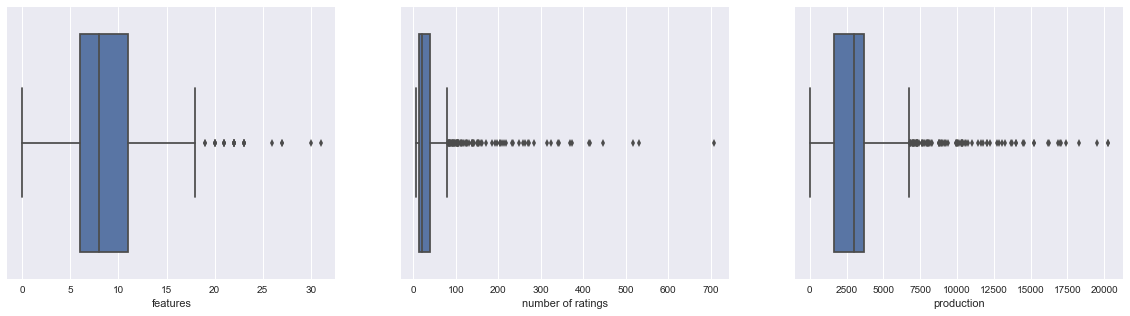

In [22]:
plt.figure(figsize=(20,5))

plt.subplot(1, 3, 1)
sns.boxplot(pinball_data_clean.features)

plt.subplot(1, 3, 2)
sns.boxplot(pinball_data_clean['number of ratings'])

plt.subplot(1, 3, 3)
sns.boxplot(pinball_data_clean['production'])

In [32]:
pinball_data_clean['sqrt_features'] = np.sqrt(pinball_data_clean['features'])
pinball_data_clean['number of ratings'] = pinball_data_clean['number of ratings'] + 1
pinball_data_clean['log_ratings'] = np.log(pinball_data_clean['number of ratings'])
pinball_data_clean['sqrt_production'] = np.sqrt(pinball_data_clean['production'])
pinball_data_clean.head()

,features,machine type,manufacture date,manufacturer,name,number of ratings,production,rating,specialty,theme,days since,sqrt_features,sqrt_ratings,sqrt_production,log_production,log_ratings
0,0,Electro-mechanical (EM),1936-04-07,Chicago Coin Machine Manufacturing Company (19...,Monopolee,9.0,127.000000,6.0,Payout Machine,none,24202.0,0.000000,2.449490,11.269428,4.844187,2.197225
1,5,Electro-mechanical (EM),1947-10-25,D. Gottlieb & Company (1931-1977),Humpty Dumpty,10.0,6500.000000,6.7,none,Fictional Characters,28420.0,2.236068,2.645751,80.622577,8.779557,2.302585
2,6,Electro-mechanical (EM),1950-12-01,D. Gottlieb & Company (1931-1977),Knock Out,17.0,3000.000000,7.1,none,Sports - Boxing,29553.0,2.449490,3.741657,54.772256,8.006368,2.833213
3,26,Electro-mechanical (EM),1951-02-01,Chicago Coin Machine Manufacturing Company (19...,Thing,9.0,3539.144663,8.5,none,none,29615.0,5.099020,2.449490,59.490711,8.171640,2.197225
4,7,Electro-mechanical (EM),1951-02-01,D. Gottlieb & Company (1931-1977),Minstrel Man,14.0,1800.000000,7.4,none,American History - Music - Singing - Dancing,29615.0,2.645751,3.316625,42.426407,7.495542,2.639057


## Baseline

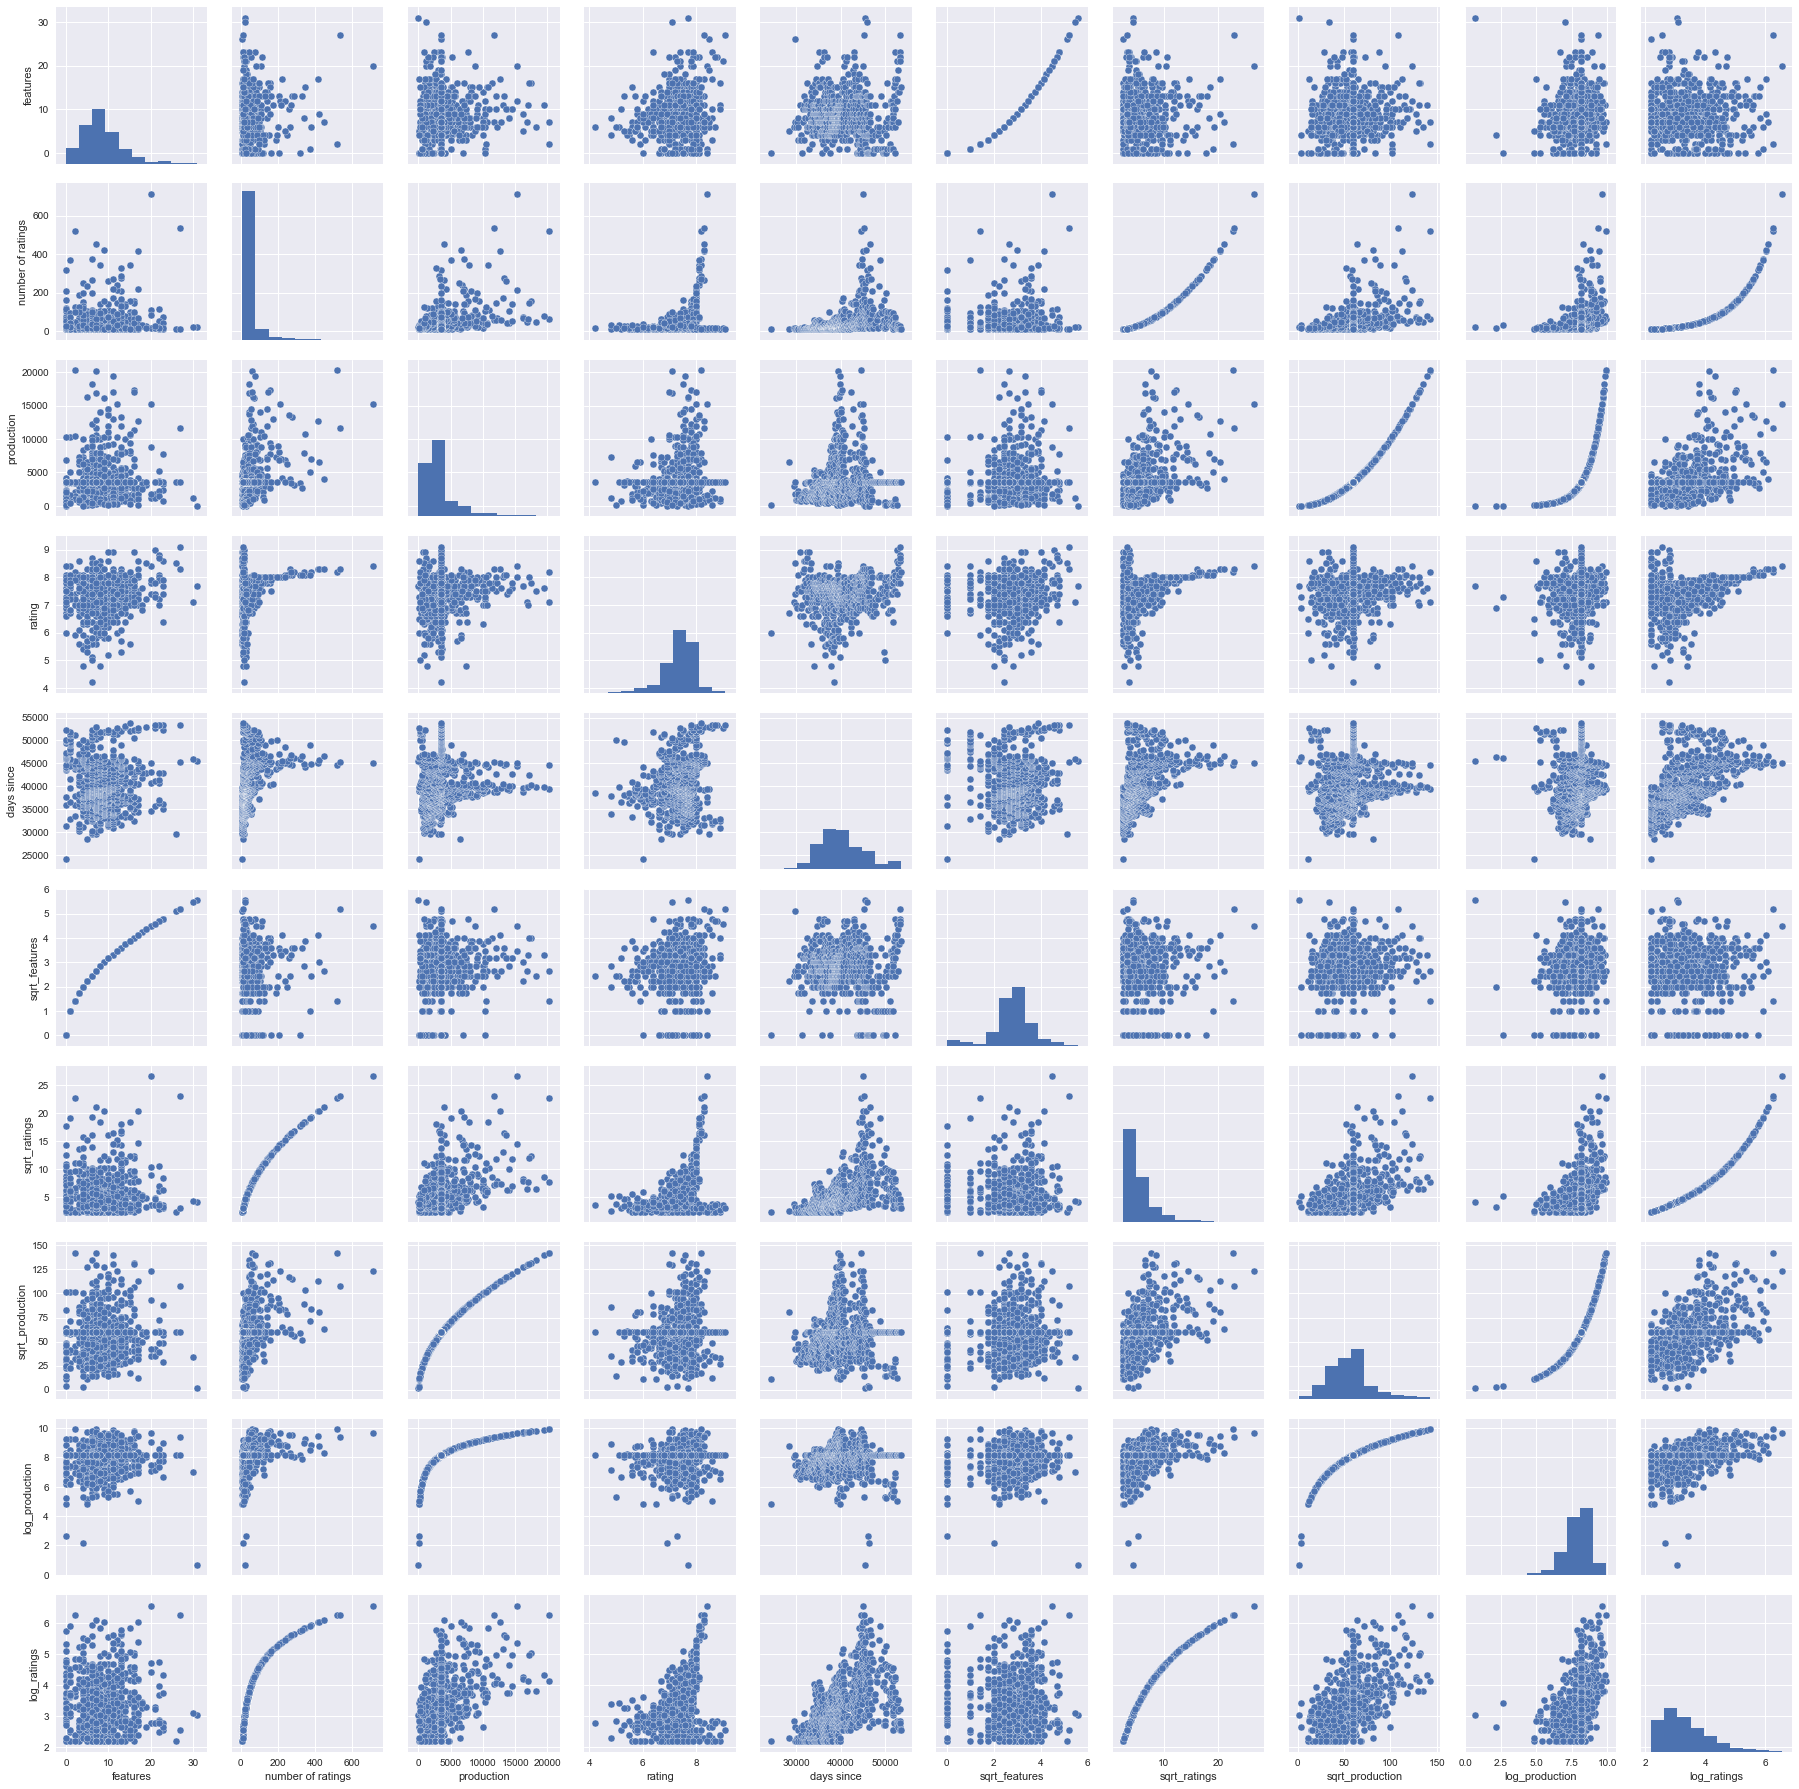

In [33]:
sns.pairplot(pinball_data_clean)

In [34]:
pinball_data_clean.corr()

,features,number of ratings,production,rating,days since,sqrt_features,sqrt_ratings,sqrt_production,log_production,log_ratings
features,1.000000,0.076319,0.079013,0.181241,0.014040,0.946131,0.057973,0.083479,0.064480,0.042166
number of ratings,0.076319,1.000000,0.452194,0.326612,0.358476,0.028546,0.944822,0.431074,0.347816,0.818063
production,0.079013,0.452194,1.000000,0.115782,0.095900,0.083835,0.507497,0.962363,0.796410,0.514882
rating,0.181241,0.326612,0.115782,1.000000,0.154440,0.151757,0.357208,0.101712,0.071654,0.343111
days since,0.014040,0.358476,0.095900,0.154440,1.000000,-0.081241,0.467012,0.097688,0.049710,0.525772
sqrt_features,0.946131,0.028546,0.083835,0.151757,-0.081241,1.000000,0.010602,0.093351,0.092517,-0.001186
sqrt_ratings,0.057973,0.944822,0.507497,0.357208,0.467012,0.010602,1.000000,0.502972,0.422210,0.958864
sqrt_production,0.083479,0.431074,0.962363,0.101712,0.097688,0.093351,0.502972,1.000000,0.918226,0.524753
log_production,0.064480,0.347816,0.796410,0.071654,0.049710,0.092517,0.422210,0.918226,1.000000,0.452215
log_ratings,0.042166,0.818063,0.514882,0.343111,0.525772,-0.001186,0.958864,0.524753,0.452215,1.000000


/Users/anagiraldo-w/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


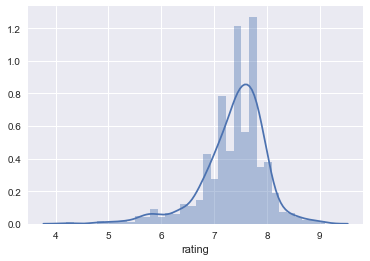

In [35]:
sns.distplot(pinball_data_clean['rating'])

In [43]:
x_data = pinball_data_clean.loc[:,['name', 'sqrt_features', 'machine type', 'manufacturer', 'number of ratings', 'log_ratings', 'production', 'sqrt_production', 'specialty', 'theme','days since']]
y_data = pinball_data_clean.loc[:,['rating']]
X, X_holdout, y, y_holdout = train_test_split(x_data, y_data, test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

In [57]:
X_1 = X_train['log_ratings']
X1_test = X_test['log_ratings']
y_1 = y_train['rating']

In [58]:
model = sm.OLS(y_train,sm.add_constant(X_1))
results = model.fit()
y_pred = results.predict(sm.add_constant(X1_test))
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     86.78
Date:                Sun, 30 Sep 2018   Prob (F-statistic):           2.26e-19
Time:                        22:58:32   Log-Likelihood:                -499.32
No. Observations:                 604   AIC:                             1003.
Df Residuals:                     602   BIC:                             1011.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           6.5423      0.093     70.294      0.000       6.359       6.725
log_ratings     0.2541      0.027      9.316      0.000       0.201       0.308
==============================================================================
Omnibus:                       91.805   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              269.431
Skew:                          -0.735   Prob(JB):                     3.12e-59
Kurtosis:                       5.923   Cond. No.                         15.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
type(y_pred)

pandas.core.series.Series

In [60]:
def single_regression_plot(x, y, y_pred):
    plt.figure(figsize=(20,5))

    plt.subplot(1, 3, 1)
    plt.scatter(y_pred, y, alpha=0.2)
    plt.plot(np.linspace(6,10,1000), np.linspace(5.7,10,1000), color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - y_pred
    plt.scatter(y_pred, res, alpha=0.2)
    plt.plot(np.linspace(5,10,1000), np.linspace(0,0,1000))
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

/Users/anagiraldo-w/anaconda3/lib/python3.6/site-packages/pandas/core/indexes/base.py:3755: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  return this.join(other, how=how, return_indexers=return_indexers)


ValueError: x and y must be the same size

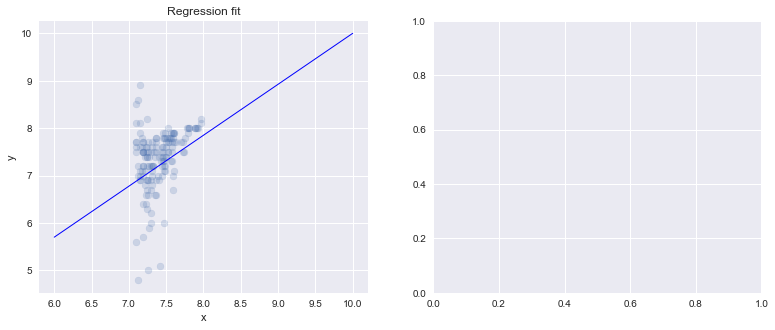

In [61]:
single_regression_plot(X1_test, y_test, y_pred)

## Multiple Linear Regression ##  
  
No categorical

In [ ]:
selected = ['number of ratings', 'features', 'production', 'days since']]

In [ ]:
from sklearn.metrics import mean_squared_error

def RMSE(actual, predicted):
    return np.sqrt(mean_squared_error(actual,predicted)) 

In [ ]:
lm = LinearRegression()
lm.fit(X_train.loc[:,selected], y_train)
y_pred = lm.predict(X_test.loc[:,selected])
scores = cross_val_score(lm, X_test.loc[:,selected], y_test, cv=kfold, scoring='mean_squared_error')
print('Multiple Linear regression val R^2: %.3f' 
      % lm.score(X_test.loc[:,selected], y_test))
print('Multiple Linear regression score val RMSE: %.3f' 
      % RMSE(lm.predict(X_test.loc[:,selected]), y_test))
print(-scores)

In [ ]:
def multiple_regression_plot(x, y, y_pred):
    plt.figure(figsize=(20,5))
    
    plt.subplot(1, 2, 1)
    res = y - y_pred
    plt.scatter(y_pred, res, alpha=0.2)
    plt.plot(np.linspace(5,10,1000), np.linspace(0,0,1000))
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 2, 2)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res['rating'], dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

In [ ]:
multiple_regression_plot(X_test.loc(:,selected), y_test, y_pred)

## Encoding Categorical ##


In [ ]:
selected = ['features', 'number of ratings', 'production', 'machine type','days since', 'specialty']
X_3_train = pd.get_dummies(X_train.loc[:,selected])
X_3_test = pd.get_dummies(X_test.loc[:,selected])
X_3_train.head()

In [ ]:
lm2 = LinearRegression()
lm2.fit(X_3_train, y_train)
y_pred = lm2.predict(X_3_test)
scores = cross_val_score(lm2, X_3_test, y_test, cv=kfold, scoring='mean_squared_error')
print('Multiple Linear regression val R^2: %.3f' 
      % lm2.score(X_3_test, y_test))
print('Multiple Linear regression score val RMSE: %.3f' 
      % RMSE(lm2.predict(X_3_test), y_test))
print(-scores)

In [ ]:
multiple_regression_plot(X_3_test, y_test, y_pred)

## Polynomial Regression ##

In [ ]:
def add_poly_terms(df):    
    
    df_poly = df.copy()
    
    for c in df.columns:
        df_poly[c + '**2'] = df[c]**2
        df_poly[c + '**3'] = df[c]**3
        
        
    return df_poly

In [ ]:
X_4 = add_poly_terms(X_3)
X_4['log ratings'] = np.log(X_4['number of ratings'])

lm3 = LinearRegression()
lm3.fit(X_4, y_train)

y_pred = lm3.predict(X_4)
scores = cross_val_score(lm3, X_4, y_train, cv=kfold, scoring='mean_squared_error')
print('Multiple Linear regression val R^2: %.3f' 
      % lm3.score(X_4, y_train))
print('Multiple Linear regression score val RMSE: %.3f' 
      % RMSE(lm3.predict(X_4), y_train))
print(-scores)

In [ ]:
multiple_regression_plot(X_4, y_train, y_pred)

In [ ]:
X_4.head()

## Standardization and LASSO Regularization

In [ ]:
std = StandardScaler()
std.fit(X_4)
X_tr = std.transform(X_4)

In [ ]:
alphavec = 10**np.linspace(-3,9,27)

lm5= LassoCV(alphas = alphavec, cv=kfold)
lm5.fit(X_tr,y_train)

In [ ]:
lm5.alpha_

In [ ]:
X_tr = pd.DataFrame(X_tr)
list(zip(X_tr.columns,lm5.coef_))

In [ ]:
y_pred = lm5.predict(X_tr)
scores = cross_val_score(lm5, X_tr, y_train, cv=kfold, scoring='mean_squared_error')
print('Multiple Linear regression val R^2: %.3f' 
      % lm5.score(X_tr, y_train))
print('Multiple Linear regression score val RMSE: %.3f' 
      % RMSE(lm5.predict(X_tr), y_train))
print(-scores)

In [ ]:
single_regression_plot(X_tr, y_1, y_pred)

## Final Test ##

In [ ]:
X_5 = X_holdout.loc[:,['features', 'number of ratings', 'production', 'machine type','days since', 'specialty']]
X_5.head()

In [ ]:
X_final = pd.get_dummies(X_5, ['machine type', 'specialty'])
X_final['log ratings'] = np.log(X_final['number of ratings'])
X_fin = add_poly_terms(X_final)
X_fin.head()

In [ ]:
std = StandardScaler()
std.fit(X_4)
X_tr = std.transform(X_4)

y_pred = lm4.predict(X_fin)
scores = cross_val_score(lm4, X_fin, y_holdout, cv=kfold, scoring='mean_squared_error')
print('Multiple Linear regression val R^2: %.3f' 
      % lm4.score(X_fin, y_holdout))
print('Multiple Linear regression score val RMSE: %.3f' 
      % RMSE(lm4.predict(X_fin), y_holdout))
print(-scores)

In [ ]:
multiple_regression_plot(X_fin, y_holdout, y_pred)

In [ ]:
lm4.coef_[0]
X_fin.head(20)

In [ ]:
list(zip(X_fin.columns,lm4.coef_[0]))